In [1]:
import data
import torch
from torch.distributions import Normal, Categorical, kl_divergence
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Model definitions

In [4]:
class Model(nn.Module):
    def __init__(self, num_actions, beta=10, alpha=0.0):
        super(Model, self).__init__()
        self.beta = beta
        self.params = nn.Parameter(torch.zeros(3, num_actions))
        self.optimizer = optim.SGD(self.parameters(), lr=alpha)

    def forward(self, utilities):
        self.probabilities = F.softmax(self.params, dim=1)
        joint_prior = torch.einsum('i,j,k->ijk', self.probabilities[0], self.probabilities[1], self.probabilities[2]).flatten()

        posterior = joint_prior * torch.exp(self.beta * utilities)
        posterior = posterior / posterior.sum()

        return Categorical(posterior).sample(), kl_divergence(Categorical(posterior), Categorical(joint_prior)).item()  

    def learn(self, action):
        prior = Categorical(self.probabilities)
        loss = -prior.log_prob(combinations[action] + 10).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [5]:
# A simpler model that always chooses the action with the highest utility without considering costs.
class RationalModel(nn.Module):
    def __init__(self):
        super(RationalModel, self).__init__()

    def forward(self, utilities):
        return torch.argmax(utilities), 0  # If it is rational, it will return the combination with the highest utility. And thus the KLD is 0.

    def learn(self, action):
        pass

In [2]:
experiments = [data.default, data.control, data.less_e, data.more_e, data.alternating, data.extreme]
num_runs = 100

# only search for weights between -10 and +10
# This range denotes the possible coefficients that could be used with the jars to measure a specific amount of water.
values = torch.arange(-10, 11, 1) 

# All combinations of the possible values.
combinations = torch.cartesian_prod(values, values, values)

In [7]:
def simulate(experiments, num_runs, gamma, bounded, alphas, betas):
    for num_experiment, experiment in enumerate(experiments):
        x, y = experiment()

        # precompute utilities
        # x is jar capacities, combinations is the all combinations, 
        optimality = ((combinations.float() @ x.t()) == y).double()
        utilities = optimality - gamma * (combinations ** 2).sum(-1, keepdims=True)

        num_correct = torch.zeros(num_runs, len(alphas), len(betas), x.shape[0])
        num_d_solution = torch.zeros(num_runs, len(alphas), len(betas), x.shape[0])
        num_e_solution = torch.zeros(num_runs, len(alphas), len(betas), x.shape[0])
        klds = torch.zeros(num_runs, len(alphas), len(betas), x.shape[0])

        for alpha_idx, alpha in enumerate(alphas):
            print(alpha_idx)
            for beta_idx, beta in enumerate(betas):
                for run in range(num_runs):
                    if bounded:
                        model = Model(values.shape[0], beta, alpha)
                    else:
                        model = RationalModel()
                    for i in range(x.shape[0]):
                        # inference
                        action, kld = model(utilities[:, i]) # With the prior it decides the action. The solution can be wrong, Einstellung, or direct
                        klds[run, alpha_idx, beta_idx, i] = kld # Could be 0 if our model is rational or between 0 and 1.
                        # adjust prior
                        model.learn(action) # Basically you have a new prior since you learned something.

                        # If the action is optimal, or correct if you will.
                        if optimality[action, i].bool().item(): 
                            num_correct[run, alpha_idx, beta_idx, i] +=1
                        
                        # If the sum of squares of the coefficients in the action is less than 6 then it is a direct solution
                        if optimality[action, i].bool().item() and combinations[action].pow(2).sum() < 6:  
                            num_d_solution[run, alpha_idx, beta_idx, i] +=1
                        
                        # If the sum of squares of the coefficients in the action is exactly 6 then it is an Einstellung solution
                        if optimality[action, i].bool().item() and combinations[action].pow(2).sum() == 6:
                            num_e_solution[run, alpha_idx, beta_idx, i] +=1
        torch.save([num_correct, num_d_solution, num_e_solution, klds], 'data/exp' + str(num_experiment) + '_gamma_' + str(gamma) + '_bounded_' + str(bounded) + '.pth')

# Simulate full model

In [11]:
gamma = 0.05
bounded = True # That means our model is not perfectly rational. There is a cost of changing prior to posterior.

alphas = torch.linspace(0., 1, 21)  # 0, 0.05, 0.1, 0.15, 0.2, ...
betas = torch.linspace(1, 50, 50)   # 1, 2, 3, 4, 5, ...

simulate(experiments, num_runs, gamma, bounded, alphas, betas)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


# Simulate model with no physical effort

In [23]:
gamma = 0.00
bounded = True

alphas = torch.linspace(0., 1, 21)
betas = torch.linspace(1, 50, 50)

simulate(experiments, num_runs, gamma, bounded, alphas, betas)

NameError: name 'simulate' is not defined

# Simulate rational model

In [ ]:
gamma = 0.05
bounded = False

alphas = torch.linspace(1, 1, 1)
betas = torch.linspace(1, 1, 1)

simulate(experiments, num_runs, gamma, bounded, alphas, betas)

# Analyze Results

In [16]:
from enum import Enum, auto
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

class ExperimentEnum(Enum):
    DEFAULT = 0
    CONTROL = 1
    LESS_E = 2
    MORE_E = 3
    ALTERNATING = 4
    EXTREME = 5

Matplotlib is building the font cache; this may take a moment.


In [17]:
def get_einstellung_percentage(experiment, alphas, betas, alpha, beta, bounded=True, gamma="0.05"):
    file_path = f"data/exp{experiment.value}_gamma_{gamma}_bounded_{bounded}.pth"
    
    # Load the saved tensors
    num_correct, num_d_solution, num_e_solution, klds = torch.load(file_path)
    
    # Get the indices for the specified alpha and beta
    alpha_idx = (torch.abs(alphas - alpha)).argmin().item()
    beta_idx = (torch.abs(betas - beta)).argmin().item()
    
    # Extract the relevant slices for the given alpha and beta
    einstellung_solutions = num_e_solution[:, alpha_idx, beta_idx, :]
    
    # Calculate the percentage of Einstellung solutions for each problem
    einstellung_percentage = einstellung_solutions.mean(0).numpy() * 100
    
    return einstellung_percentage

In [18]:
def show_combined_plot(mean_exp_c1c2, mean_ctrl_c1c2, mean_exp_c3c4, mean_ctrl_c3c4, name1, name2):
    # Construct DataFrame
    data = {
        'Group': [name1, name2, name1, name2],
        'response': ['C1/C2', 'C1/C2', 'C3/C4', 'C3/C4'],
        'p': [mean_exp_c1c2, mean_ctrl_c1c2, mean_exp_c3c4, mean_ctrl_c3c4],
        'se': [0, 0, 0, 0]  # Placeholder for standard error if available
    }

    df = pd.DataFrame(data)

    # Plotting
    sns.set(style="whitegrid")
    g = sns.catplot(x="Group", y="p", hue="Group", col="response", data=df, kind="bar", palette="pastel", height=4, aspect=1)
    g.set(ylim=(0, 100))
    g.set_axis_labels("Condition", "% Einstellung solutions")
    g.set_titles("{col_name}")

    # Add error bars if se is not zero
    for index, row in df.iterrows():
        g.axes.flat[index % 2].errorbar(index % 2, row['p'], yerr=row['se'], fmt='none', c='black')

    plt.show()

In [19]:
def plot_alpha_effect_on_einstellung(means, alphas):
    # Construct DataFrame
    data = {
        'Alpha': alphas,
        'Mean Einstellung %': means
    }

    df = pd.DataFrame(data)

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    p = sns.lineplot(x="Alpha", y="Mean Einstellung %", data=df, marker='o')
    p.set(ylim=(0, 100))
    p.set_title("Effect of Alpha on Einstellung Solution Percentages")
    p.set_xlabel("Alpha")
    p.set_ylabel("Mean Einstellung %")
    plt.show()

In [20]:
def calculate_mean_for_indices(einstellung_percentages, indices):
    return einstellung_percentages[indices].mean()

In [21]:
alphas = torch.linspace(0., 1, 21)
betas = torch.linspace(1, 50, 50)

# 1- Main Einstellung Effect

In [22]:
experiment_default = ExperimentEnum.DEFAULT
experiment_control = ExperimentEnum.CONTROL

einstellung_percentage_default = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.5, beta=25)
einstellung_percentage_ctrl = get_einstellung_percentage(experiment_control, alphas, betas, alpha=0.5, beta=25)

In [23]:
mean_exp_c1c2 = calculate_mean_for_indices(einstellung_percentage_default, [5, 6])
mean_ctrl_c1c2 = calculate_mean_for_indices(einstellung_percentage_ctrl, [0,1])

mean_exp_c3c4 = calculate_mean_for_indices(einstellung_percentage_default, [8, 9])
mean_ctrl_c3c4 = calculate_mean_for_indices(einstellung_percentage_ctrl, [3,4])

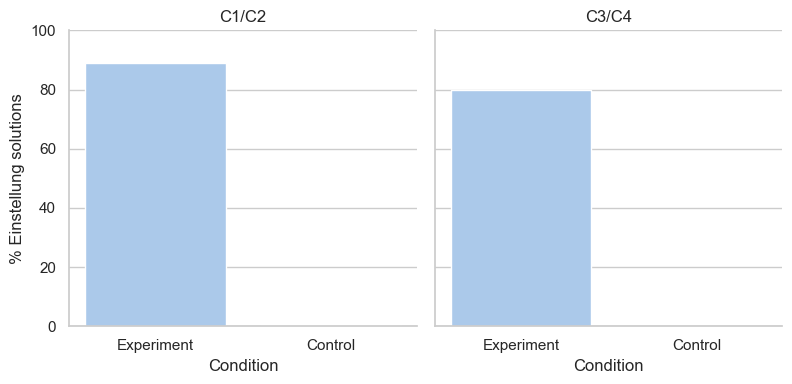

In [24]:
show_combined_plot(mean_exp_c1c2, mean_ctrl_c1c2, mean_exp_c3c4, mean_ctrl_c3c4, "Experiment", "Control")

# 2- DBB

In [25]:
experiment_default = ExperimentEnum.DEFAULT

einstellung_percentage_default = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.5, beta=25)
einstellung_percentage_dbb = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.5, beta=30)

In [26]:
mean_exp_c1c2 = calculate_mean_for_indices(einstellung_percentage_default, [5, 6])
mean_dbb_c1c2 = calculate_mean_for_indices(einstellung_percentage_dbb, [5, 6])

mean_exp_c3c4 = calculate_mean_for_indices(einstellung_percentage_default, [8, 9])
mean_dbb_c3c4 = calculate_mean_for_indices(einstellung_percentage_dbb, [8, 9])

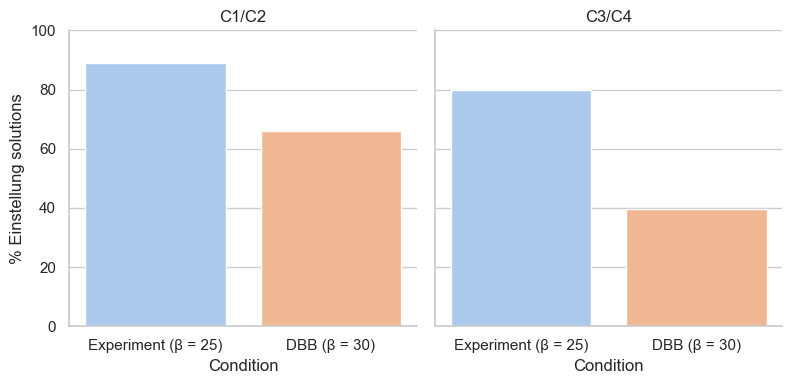

In [27]:
show_combined_plot(mean_exp_c1c2, mean_dbb_c1c2, mean_exp_c3c4, mean_dbb_c3c4, f"Experiment (β = 25)", "DBB (β = 30)")

# 3- Varying The Number of Training Tasks

In [28]:
experiment_less_e = ExperimentEnum.LESS_E
experiment_more_e = ExperimentEnum.MORE_E

einstellung_percentage_less_e = get_einstellung_percentage(experiment_less_e, alphas, betas, alpha=0.5, beta=15)
einstellung_percentage_more_e = get_einstellung_percentage(experiment_more_e, alphas, betas, alpha=0.5, beta=15)

In [29]:
mean_less_e_c1c2 = calculate_mean_for_indices(einstellung_percentage_less_e, [2, 3])
mean_more_e_c1c2 = calculate_mean_for_indices(einstellung_percentage_more_e, [10, 11])

mean_less_e_c3c4 = calculate_mean_for_indices(einstellung_percentage_less_e, [5, 6])
mean_more_e_c3c4 = calculate_mean_for_indices(einstellung_percentage_more_e, [13, 14])

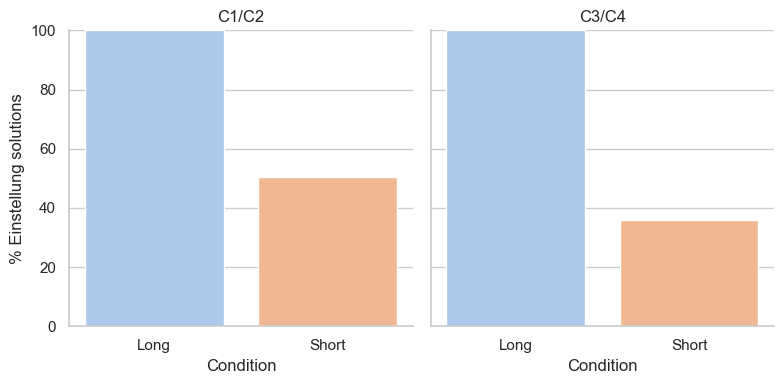

In [30]:
show_combined_plot(mean_more_e_c1c2, mean_less_e_c1c2, mean_more_e_c3c4, mean_less_e_c3c4, "Long", "Short")

# 4- Interleaving E and D Problems

In [31]:
experiment_alternating = ExperimentEnum.ALTERNATING
experiment_extreme = ExperimentEnum.EXTREME

einstellung_percentage_alternating = get_einstellung_percentage(experiment_alternating, alphas, betas, alpha=0.5, beta=25)
einstellung_percentage_extreme = get_einstellung_percentage(experiment_extreme, alphas, betas, alpha=0.5, beta=25)

In [32]:
mean_alternating_c1c2 = calculate_mean_for_indices(einstellung_percentage_alternating, [6, 7])
mean_extreme_c1c2 = calculate_mean_for_indices(einstellung_percentage_extreme, [6, 7])

mean_alternating_c3c4 = calculate_mean_for_indices(einstellung_percentage_alternating, [4, 2])
mean_extreme_c3c4 = calculate_mean_for_indices(einstellung_percentage_extreme, [9, 10])

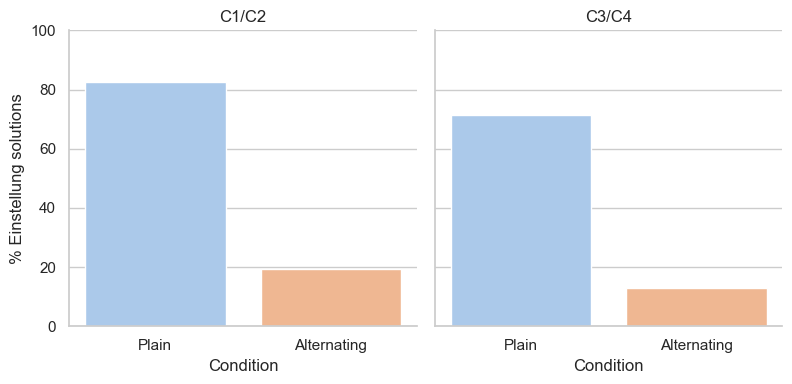

In [33]:
show_combined_plot(mean_extreme_c1c2, mean_alternating_c1c2, mean_extreme_c3c4, mean_alternating_c3c4, "Plain", "Alternating")

# 5- Adding Time Pressure

In [34]:
experiment_default = ExperimentEnum.DEFAULT

einstellung_percentage_plain = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.5, beta=25)
einstellung_percentage_speedy = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.5, beta=15)

In [35]:
mean_plain_c1c2 = calculate_mean_for_indices(einstellung_percentage_plain, [5, 6])
mean_speedy_c1c2 = calculate_mean_for_indices(einstellung_percentage_speedy, [0, 1])

mean_plain_c3c4 = calculate_mean_for_indices(einstellung_percentage_plain, [8, 9])
mean_speedy_c3c4 = calculate_mean_for_indices(einstellung_percentage_speedy, [3, 4])

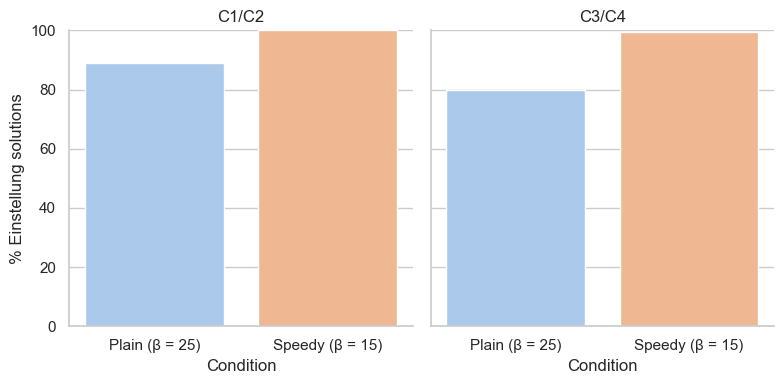

In [36]:
show_combined_plot(mean_plain_c1c2, mean_speedy_c1c2, mean_plain_c3c4, mean_speedy_c3c4, "Plain (β = 25)", "Speedy (β = 15)")

# 6- Age Factor

In [37]:
experiment_default = ExperimentEnum.DEFAULT

age_beta=30

ep_alpha_45 = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.45, beta=age_beta)
ep_alpha_50 = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.50, beta=age_beta)
ep_alpha_55 = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.55, beta=age_beta)
ep_alpha_60 = get_einstellung_percentage(experiment_default, alphas, betas, alpha=0.60, beta=age_beta)

In [39]:
mean_45 = calculate_mean_for_indices(ep_alpha_45, [5, 6])
mean_50 = calculate_mean_for_indices(ep_alpha_50, [5, 6])
mean_55 = calculate_mean_for_indices(ep_alpha_55, [5, 6])
mean_60 = calculate_mean_for_indices(ep_alpha_60, [5, 6])

In [40]:
means = [mean_45, mean_50, mean_55, mean_60]
age_alphas = [0.45, 0.50, 0.55, 0.60]

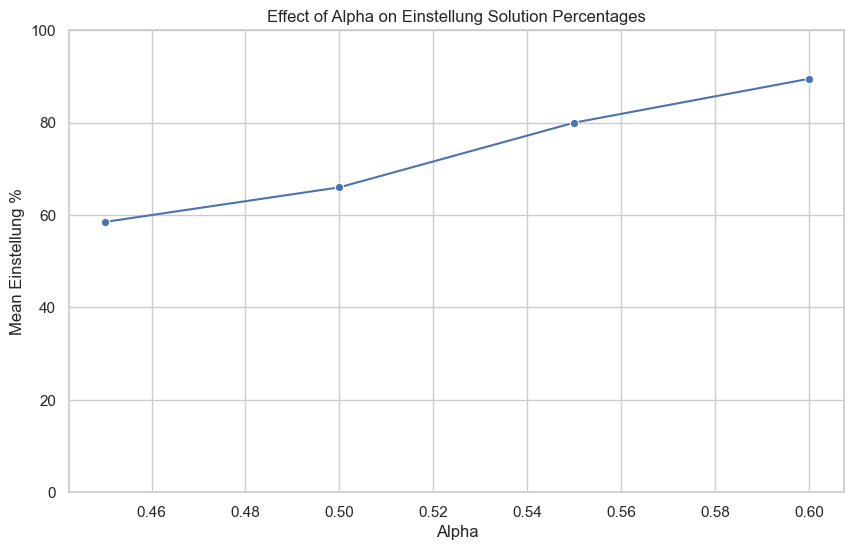

In [41]:
plot_alpha_effect_on_einstellung(means, age_alphas)